# Some stuff with project data

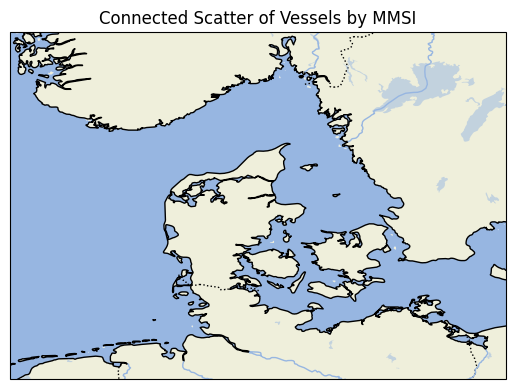

In [4]:
from dataloader import plot_paths_on_map

plot_paths_on_map(None)

/zhome/b1/8/213657/DeepLearning/dataloader.py:148: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")


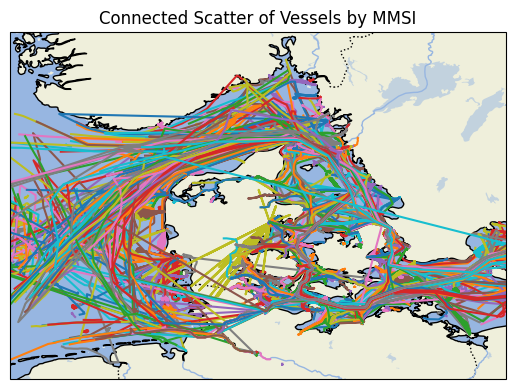

In [5]:
from dataloader import load_parquet
MY_FILE = "dataset"
df = load_parquet(MY_FILE, k=1000)
plot_paths_on_map(df)

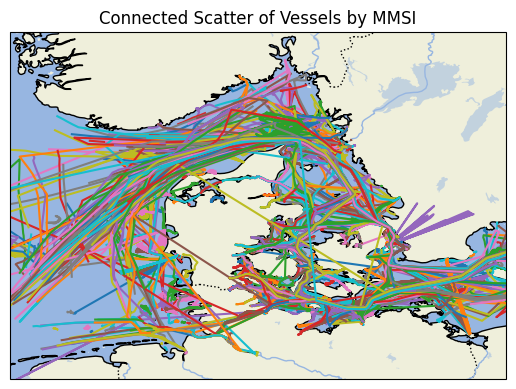

In [6]:
from dataloader import preprocess_data

df = preprocess_data(df)
plot_paths_on_map(df)

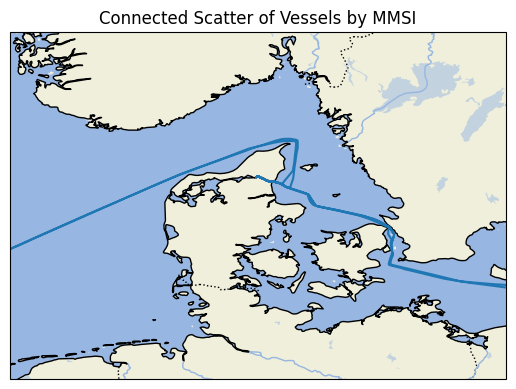

In [3]:
from dataloader import get_ID_by_coords    

weird = []
weird.append(get_ID_by_coords(df, 54.16, 9.50))
weird.append(get_ID_by_coords(df, 53.5, 6.5))
plot_paths_on_map(df[df["MMSI"].isin(["MMSI=209525000"])])

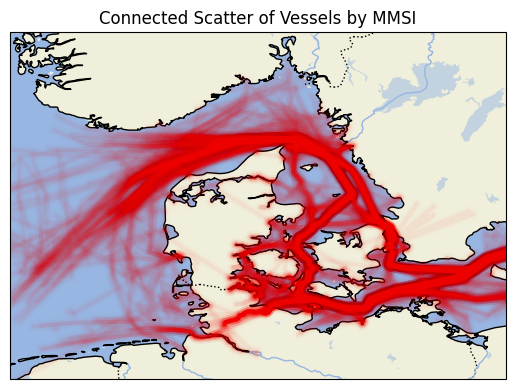

In [ ]:
plot_paths_on_map(df, heat=[(9, 0.005), (6, 0.01), (3, 0.05)])

On paper that veronika sent:
- Turn trajectories into heatmaps
- Turn heatmaps into series of numbers (with environmental information like land (-99)), f.ex.:
  - -99 -99 -99 0 0 0 1 4 5  10 6 4 3 0 0   0   -99 -99 
  - -99 -99 0   0 0 1 4 5 10 6  4 3 0 0 0   0   -99 -99 
  - -99 -99 0   0 1 3 4 8 8  5  2 0 0 0 -99 -99 -99 -99 
- Train model on predicting the next line (so we always have to rotate our input data according to the direction of travel)

# TPTrans model implementation

In [ ]:
from tptrans import train_model_from_dataset

model, loss, hist = train_model_from_dataset(k=100, epochs=200, save_model="tptrans_k100_e100")

/zhome/b1/8/213657/DeepLearning/dataloader.py:168: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")


Total dataset size: 3891
Pred len in dataset: torch.Size([10, 2])


/zhome/b1/8/213657/venv/lib64/python3.9/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/200 | Train Loss: 1648.695544 | Val Loss: 1642.248574
Epoch 2/200 | Train Loss: 1640.426852 | Val Loss: 1633.665051
Epoch 3/200 | Train Loss: 1631.966840 | Val Loss: 1624.823227
Epoch 4/200 | Train Loss: 1623.430032 | Val Loss: 1615.950279
Epoch 5/200 | Train Loss: 1615.347708 | Val Loss: 1608.576096
Epoch 6/200 | Train Loss: 1608.622871 | Val Loss: 1602.096110
Epoch 7/200 | Train Loss: 1602.464996 | Val Loss: 1595.976723
Epoch 8/200 | Train Loss: 1596.473003 | Val Loss: 1589.918820
Epoch 9/200 | Train Loss: 1590.416285 | Val Loss: 1583.727785
Epoch 10/200 | Train Loss: 1584.136229 | Val Loss: 1577.253768
Epoch 11/200 | Train Loss: 1577.542360 | Val Loss: 1570.468785
Epoch 12/200 | Train Loss: 1570.643271 | Val Loss: 1563.374898
Epoch 13/200 | Train Loss: 1563.421473 | Val Loss: 1555.954848
Epoch 14/200 | Train Loss: 1555.880964 | Val Loss: 1548.216651
Epoch 15/200 | Train Loss: 1548.024943 | Val Loss: 1540.170145
Epoch 16/200 | Train Loss: 1539.859156 | Val Loss: 1531.807822
E

/zhome/b1/8/213657/DeepLearning/dataloader.py:168: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")


Total dataset size: 45
(tensor([[1.4901e-02, 3.3005e-02, 5.6825e+01, 7.0059e+00, 6.4820e+00, 4.8900e+01],
        [1.3210e-02, 2.8990e-02, 5.6838e+01, 7.0349e+00, 6.4177e+00, 4.9625e+01],
        [1.0184e-02, 2.2490e-02, 5.6848e+01, 7.0574e+00, 6.4306e+00, 4.9400e+01],
        [1.8968e-02, 4.2467e-02, 5.6867e+01, 7.0998e+00, 6.4820e+00, 5.1380e+01],
        [6.2878e-03, 1.4321e-02, 5.6874e+01, 7.1142e+00, 6.4048e+00, 5.2875e+01],
        [1.3812e-02, 3.1682e-02, 5.6887e+01, 7.1458e+00, 6.4563e+00, 5.2570e+01],
        [1.5675e-02, 3.6319e-02, 5.6903e+01, 7.1822e+00, 6.5360e+00, 5.1635e+01],
        [1.1244e-02, 2.6048e-02, 5.6914e+01, 7.2082e+00, 6.3727e+00, 5.1575e+01],
        [1.5309e-02, 3.6043e-02, 5.6930e+01, 7.2443e+00, 6.4526e+00, 5.3786e+01],
        [1.0041e-02, 2.3516e-02, 5.6940e+01, 7.2678e+00, 6.4648e+00, 5.1608e+01],
        [1.8811e-02, 4.3969e-02, 5.6958e+01, 7.3117e+00, 6.4563e+00, 5.1200e+01],
        [9.0727e-03, 2.1112e-02, 5.6968e+01, 7.3329e+00, 6.4798e+00, 5.199

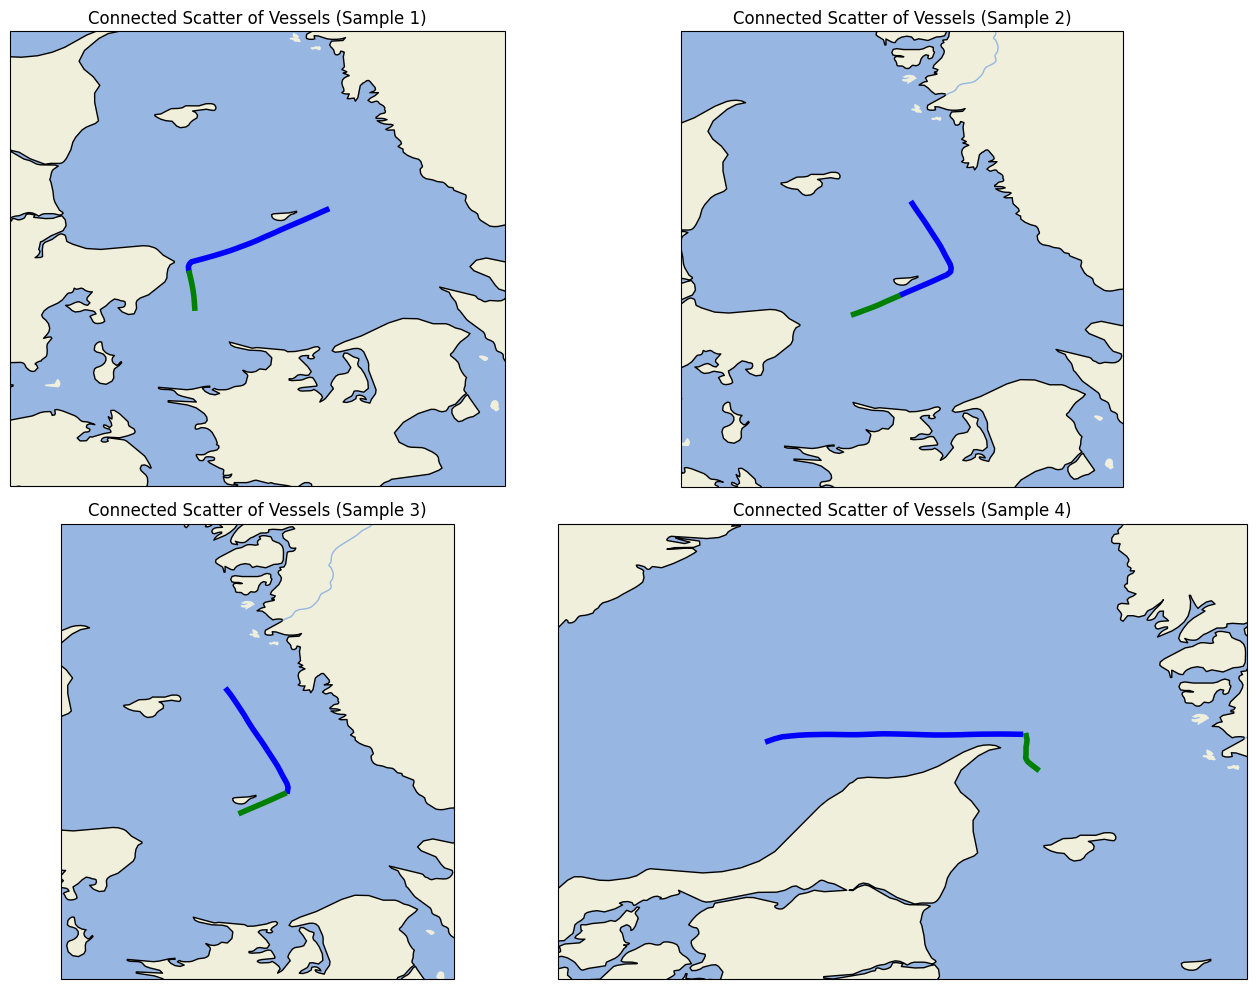

In [1]:
from dataloader import load_parquet, preprocess_data, SlidingWindowDataset
from plotting import plot_dataset_sample

df = load_parquet("dataset", k=3)
df = preprocess_data(df)

dataset = SlidingWindowDataset(
    df,
    max_diff_per_sequence_minutes=15,
    window_size_minutes=240,
    pred_size_minutes=60,
    stride=60,
)
print(f"Total dataset size: {len(dataset)}")
print(dataset[0])

plot_dataset_sample(dataset)

/zhome/b1/8/213657/DeepLearning/dataloader.py:168: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")
/tmp/ipykernel_1817548/1988637367.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

Test Loss: 0.000540


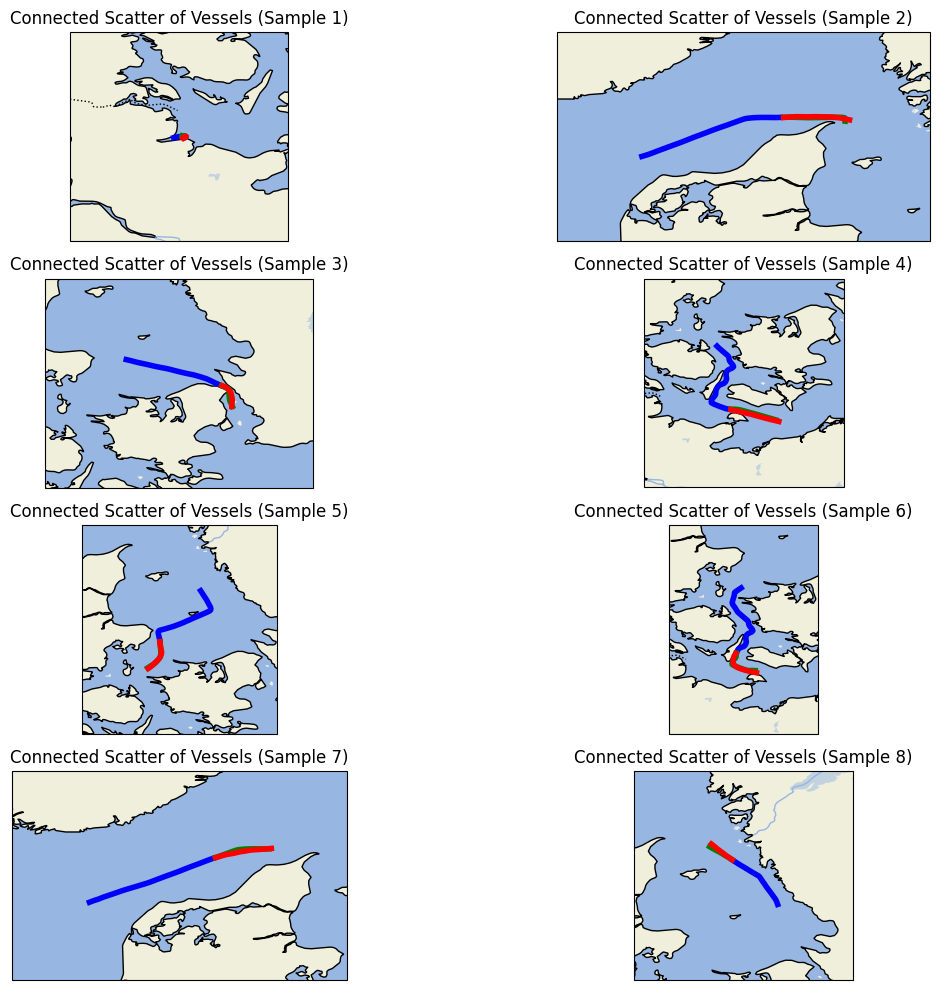

In [ ]:
import torch
import torch.nn as nn
from tptrans import *
from dataloader import load_parquet, preprocess_data, SlidingWindowDataset
from plotting import plot_testresult_sample
from torch.utils.data import DataLoader
from utils import deltas_to_coords

df = load_parquet("dataset", k=20)
df = preprocess_data(df)

dataset = SlidingWindowDataset(
    df,
    max_diff_per_sequence_minutes=15,
    window_size_minutes=420,
    pred_size_minutes=120,
    stride=15,
)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("checkpoints/t_1000_300_15_420_120_15_32_0.0001.pth", map_location=torch.device(device))
model.eval()

criterion = nn.MSELoss()
test_loss = 0.0
data = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        # split the batch into individual samples along dim=0
        x_split = torch.split(x, 1, dim=0)
        y_split = torch.split(y, 1, dim=0)
        pred_split = torch.split(pred, 1, dim=0)
        # append each sample separately
        data.extend(zip(x_split, y_split, pred_split))
        loss = criterion(deltas_to_coords(x, pred), deltas_to_coords(x,y))
        test_loss += loss.item() * x.size(0)
test_loss /= len(test_loader.dataset)
#  (heavily influenced by training dataset, so its better to ignore the test loss here and only take from log)
print(f"Test Loss: {test_loss:.6f}", flush=True)

plot_testresult_sample(data)

/zhome/b1/8/213657/DeepLearning/dataloader.py:167: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")
/tmp/ipykernel_2483102/1895725638.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

Test Loss: 0.000685


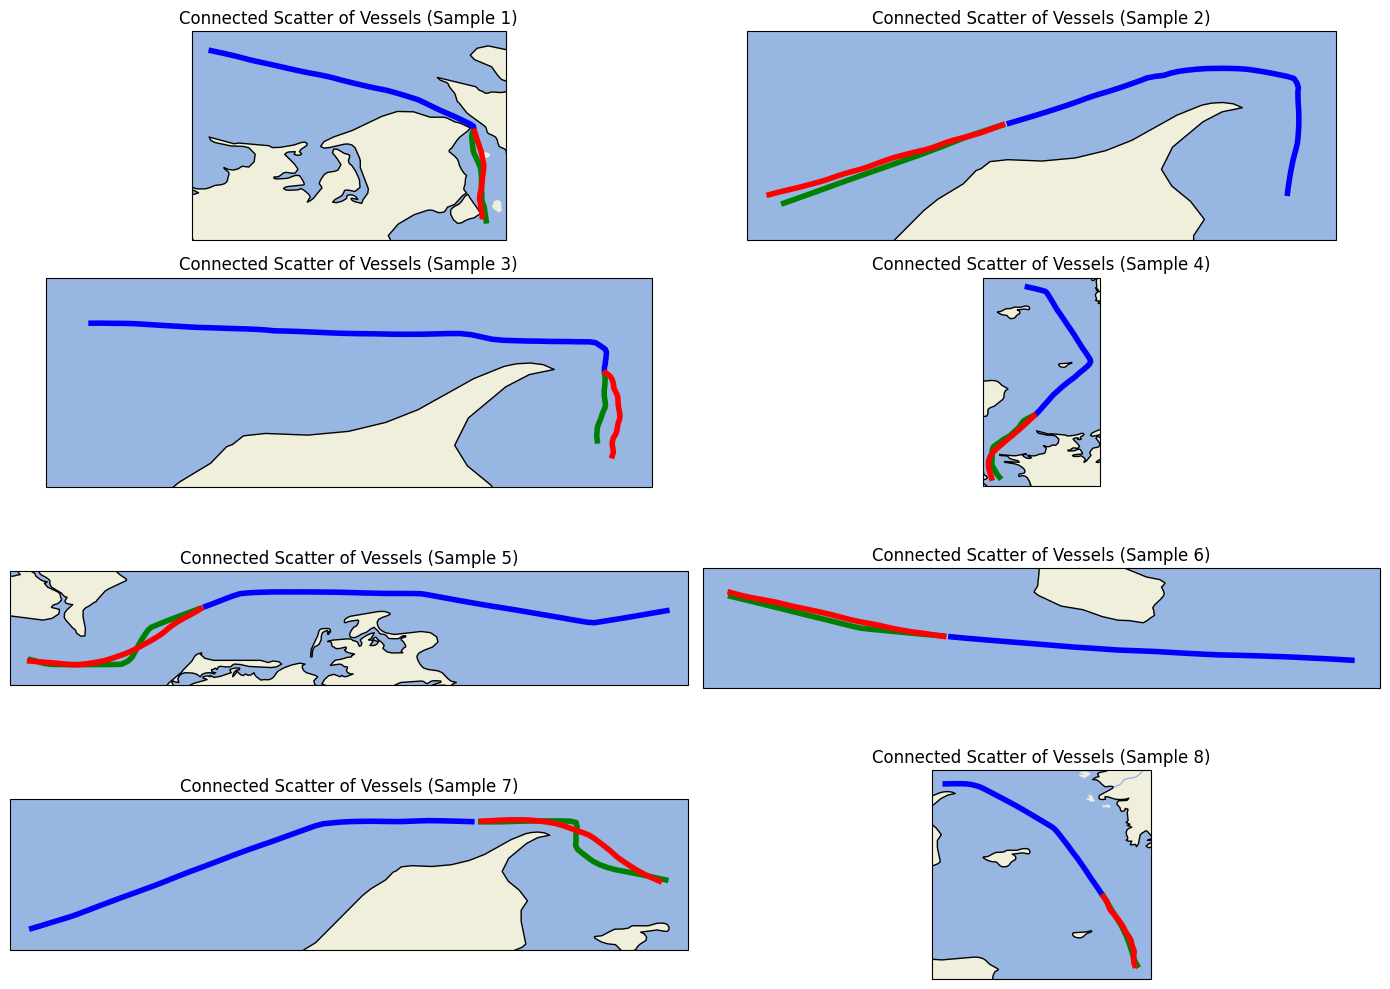

In [6]:
import torch
import torch.nn as nn
from temptpi import TempTPT, TemporalEncoding, TempTPI
from temptpi import TempTPT as TimeTPT, TemporalEncoding as BetterTemporalEncoding # some name remapping for older checkpoint files
from dataloader import load_parquet, preprocess_data, SlidingWindowDatasetTemporal
from plotting import plot_testresult_sample
from torch.utils.data import DataLoader
from utils import deltas_to_coords

df = load_parquet("dataset", k=40)
df = preprocess_data(df)

dataset = SlidingWindowDatasetTemporal(
    df,
    max_diff_per_sequence_minutes=15,
    window_size_minutes=540,
    pred_size_minutes=180,
    stride=15,
)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("checkpoints/large_data/temptpi_1500_300_15_540_180_15_32_0.0001.pth", map_location=torch.device(device))
model.eval()

criterion = nn.MSELoss()
test_loss = 0.0
data = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        # split the batch into individual samples along dim=0
        x_split = torch.split(x, 1, dim=0)
        y_split = torch.split(y, 1, dim=0)
        pred_split = torch.split(pred, 1, dim=0)
        # append each sample separately
        data.extend(zip(x_split, y_split, pred_split))
        loss = criterion(deltas_to_coords(x, pred), deltas_to_coords(x,y))
        test_loss += loss.item() * x.size(0)
test_loss /= len(test_loader.dataset)
#  (heavily influenced by training dataset, so its better to ignore the test loss here and only take from log)
print(f"Test Loss: {test_loss:.6f}", flush=True)

plot_testresult_sample(data)

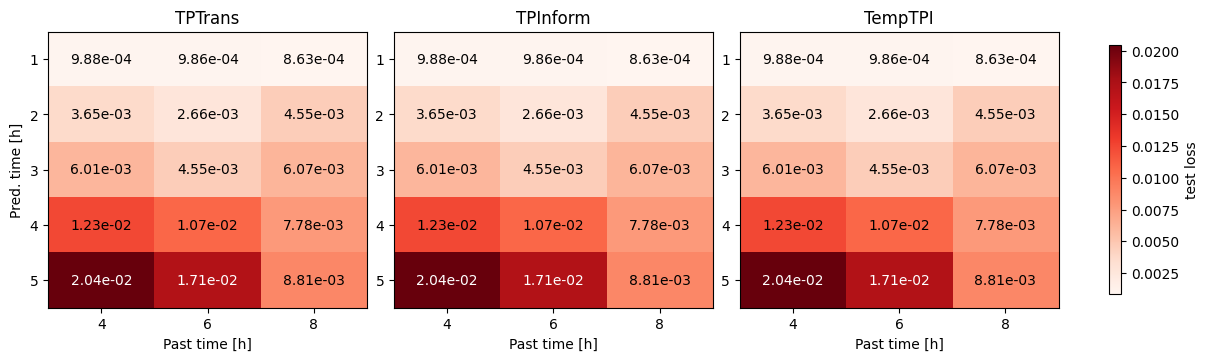

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps

# ------------------------------------------------------------
# Inputs: paths to the three CSV files
# ------------------------------------------------------------
csv_TPT = "ablation_studies/results_tptrans_b1.csv"
csv_TPI = "ablation_studies/results_tptrans_b1.csv"
csv_TTPI = "ablation_studies/results_tptrans_b1.csv"

# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
cols = ["240", "360", "480"]                       # window size columns
rows = ["60", "120", "180", "240", "300"]          # prediction horizons
titles = ["TPTrans", "TPInform", "TempTPI"]

files = [csv_TPT, csv_TPI, csv_TTPI]
datasets = []

# ------------------------------------------------------------
# Helper: convert raw CSV into matrix for each heatmap
# ------------------------------------------------------------
def make_matrix(df):
    # df entries contain window_size_minutes and pred_size_minutes
    # rows: pred_size_minutes
    # cols: window_size_minutes
    mat = np.full((len(rows), len(cols)), np.nan)

    for i, r in enumerate(rows):
        for j, c in enumerate(cols):
            val = df.loc[
                (df["pred_size_minutes"] == int(r)) &
                (df["window_size_minutes"]-df["pred_size_minutes"] == int(c)),
                "test_loss"
            ]
            if not val.empty:
                mat[i, j] = val.iloc[0]
    return mat

# ------------------------------------------------------------
# Load CSVs and build matrices
# ------------------------------------------------------------
for f in files:
    df = pd.read_csv(f)
    datasets.append(make_matrix(df))

# global color limits shared across heatmaps
vmin = np.nanmin([np.nanmin(m) for m in datasets])
vmax = np.nanmax([np.nanmax(m) for m in datasets])

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), constrained_layout=True)

cmap = colormaps["Reds"]
for e, (ax, mat, title) in enumerate(zip(axes, datasets, titles)):
    im = ax.imshow(mat, vmin=vmin, vmax=vmax, aspect="auto", cmap=cmap)
    ax.set_title(title)
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(rows)))
    ax.set_xticklabels([str(int(x)//60) for x in cols])
    ax.set_yticklabels([str(int(x)//60) for x in rows])
    ax.set_xlabel("Past time [h]")
    if e==0: 
        ax.set_ylabel("Pred. time [h]")
    # write values into cells
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if not np.isnan(mat[i, j]):
                ax.text(j, i, f"{mat[i,j]:.2e}",
                        ha="center", va="center", color="black" if mat[i,j]<0.015 else "white")

# single shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label("test loss")

plt.show()

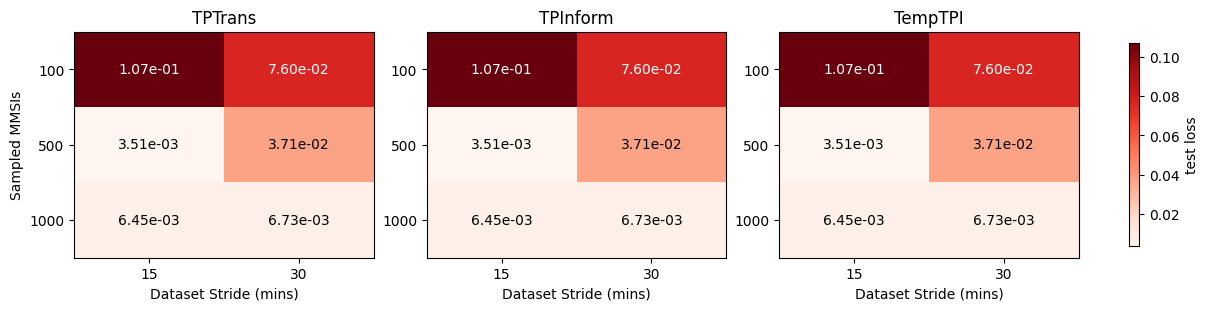

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps

# ------------------------------------------------------------
# Inputs: paths to the three CSV files
# ------------------------------------------------------------
csv_TPT = "ablation_studies/results_tptrans_b2.csv"
csv_TPI = "ablation_studies/results_tptrans_b2.csv"
csv_TTPI = "ablation_studies/results_tptrans_b2.csv"

# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
cols = ["15", "30"]                       # window size columns
rows = ["100", "500", "1000"]          # prediction horizons
titles = ["TPTrans", "TPInform", "TempTPI"]

files = [csv_TPT, csv_TPI, csv_TTPI]
datasets = []

# ------------------------------------------------------------
# Helper: convert raw CSV into matrix for each heatmap
# ------------------------------------------------------------
def make_matrix(df):
    # df entries contain window_size_minutes and pred_size_minutes
    # rows: pred_size_minutes
    # cols: window_size_minutes
    mat = np.full((len(rows), len(cols)), np.nan)

    for i, r in enumerate(rows):
        for j, c in enumerate(cols):
            val = df.loc[
                (df["k"] == int(r)) &
                (df["stride"] == int(c)),
                "test_loss"
            ]
            if not val.empty:
                mat[i, j] = val.iloc[0]
    return mat

# ------------------------------------------------------------
# Load CSVs and build matrices
# ------------------------------------------------------------
for f in files:
    df = pd.read_csv(f)
    datasets.append(make_matrix(df))

# global color limits shared across heatmaps
vmin = np.nanmin([np.nanmin(m) for m in datasets])
vmax = np.nanmax([np.nanmax(m) for m in datasets])

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)

cmap = colormaps["Reds"]
for e, (ax, mat, title) in enumerate(zip(axes, datasets, titles)):
    im = ax.imshow(mat, vmin=vmin, vmax=vmax, aspect="auto", cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel("Dataset Stride (mins)")
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(rows)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(rows)
    if e==0:
        ax.set_ylabel("Sampled MMSIs")
    # write values into cells
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if not np.isnan(mat[i, j]):
                ax.text(j, i, f"{mat[i,j]:.2e}",
                        ha="center", va="center", color="black" if mat[i,j]<0.05 else "white")

# single shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label("test loss")

plt.show()